In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# 시드 설정
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
import os

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

Reference: https://www.kaggle.com/code/baranbingl/face-shape-detection-85-acc-on-test-set

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("niten19/face-shape-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-shape-dataset


In [5]:
# 데이터 증강 및 전처리 설정
BATCH_SIZE = 32
IMG_SIZE = 380
TRAIN_PATH = path+'/FaceShape Dataset/training_set'
TEST_PATH =path+'/FaceShape Dataset/testing_set'

In [6]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet에 최적화된 전처리
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.0  # 별도의 테스트 세트가 있으므로 0으로 설정
)


In [8]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [10]:
# 클래스 수 확인
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print(f"Classes: {class_indices}")
print(f"Number of classes: {num_classes}")

Classes: {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}
Number of classes: 5


In [11]:

# EfficientNetB4 기반 모델 생성
def create_model(num_classes):
    base_model = EfficientNetB4(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )

    # 기본 모델의 가중치를 고정하지 않음 (fine-tuning)
    base_model.trainable = True

    # 모델 구성
    model = keras.Sequential([
        base_model,
        #layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(num_classes)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=5e-3,
        beta_1=0.9,
        beta_2=0.999,
        weight_decay=0.01
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
    metrics=['accuracy']
)

# 모델 구조 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,682,788 (67.45 MB)

 Trainable params: 17,557,581 (66.98 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [13]:
# 콜백 설정
callbacks = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

In [14]:
# 모델 훈련
NUM_EPOCHS = 30


history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2640 - loss: 1.6869
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.2643 - loss: 1.6862 - val_accuracy: 0.2000 - val_loss: 98.9179 - learning_rate: 0.0050
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3853 - loss: 1.4488
Epoch 2: val_accuracy improved from 0.20000 to 0.20800, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.3854 - loss: 1.4487 - val_accuracy: 0.2080 - val_loss: 8.8141 - learning_rate: 0.0050
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4546 - loss: 1.3731
Epoch 3: val_accuracy improved from 0.20800 to 0.31700, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.4548 - loss: 1.3729 - val_accuracy: 0.3170 - val_loss: 3.1172 - learning_rate: 0.0050
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5248 - loss: 1.2711
Epoch 4: val_accuracy improved from 0.31700 to 0.38300, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.5249 - loss: 1.2710 - val_accuracy: 0.3830 - val_loss: 2.1997 - learning_rate: 0.0050
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5790 - loss: 1.1912
Epoch 5: val_accuracy did not improve from 0.38300
125/125 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.5792 - loss: 1.1910 - val_accuracy: 0.2950 - val_loss: 3.8842 - learning_rate: 0.0050
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6196 - loss: 1.1159
Epoch 6: val_accuracy did not improve from 0.38300
125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.6197 - loss: 1.1157 - val_accuracy: 0.3230 - val_loss: 3.3576 - learning_rate: 0.0050
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6714 - loss: 1.0390
Epoch 7: val_accuracy improved from 0.38300 to 0.43000, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.6713 - loss: 1.0391 - val_accuracy: 0.4300 - val_loss: 2.0070 - learning_rate: 0.0050
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6871 - loss: 1.0046
Epoch 8: val_accuracy improved from 0.43000 to 0.58200, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.6871 - loss: 1.0047 - val_accuracy: 0.5820 - val_loss: 1.3196 - learning_rate: 0.0050
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7261 - loss: 0.9547
Epoch 9: val_accuracy improved from 0.58200 to 0.68300, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.7261 - loss: 0.9547 - val_accuracy: 0.6830 - val_loss: 1.0657 - learning_rate: 0.0050
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7315 - loss: 0.9309
Epoch 10: val_accuracy did not improve from 0.68300
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7316 - loss: 0.9309 - val_accuracy: 0.6020 - val_loss: 1.3169 - learning_rate: 0.0050
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7482 - loss: 0.9065
Epoch 11: val_accuracy did not improve from 0.68300
125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7482 - loss: 0.9064 - val_accuracy: 0.6740 - val_loss: 1.1196 - learning_rate: 0.0050
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7692 - loss: 0.8710
Epoch 12: val_accuracy improved from 0.68300 to 0.71700, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.7692 - loss: 0.8710 - val_accuracy: 0.7170 - val_loss: 0.9838 - learning_rate: 0.0050
Epoch 13/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7770 - loss: 0.8269
Epoch 13: val_accuracy did not improve from 0.71700
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7770 - loss: 0.8270 - val_accuracy: 0.5090 - val_loss: 1.6648 - learning_rate: 0.0050
Epoch 14/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7915 - loss: 0.8217
Epoch 14: val_accuracy did not improve from 0.71700
125/125 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.7915 - loss: 0.8216 - val_accuracy: 0.6520 - val_loss: 1.1459 - learning_rate: 0.0050
Epoch 15/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7883 - loss: 0.8204
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 15: val_accuracy did not improve from 0.71700
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7883 - loss: 0.8205 - val_

125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8419 - loss: 0.7309 - val_accuracy: 0.8300 - val_loss: 0.7589 - learning_rate: 5.0000e-04
Epoch 17/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8871 - loss: 0.6448
Epoch 17: val_accuracy did not improve from 0.83000
125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8871 - loss: 0.6448 - val_accuracy: 0.8070 - val_loss: 0.7969 - learning_rate: 5.0000e-04
Epoch 18/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9053 - loss: 0.6090
Epoch 18: val_accuracy did not improve from 0.83000
125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9053 - loss: 0.6090 - val_accuracy: 0.8300 - val_loss: 0.7456 - learning_rate: 5.0000e-04
Epoch 19/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9099 - loss: 0.6076
Epoch 19: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.

Epoch 19: val_accuracy did not improve from 0.83000
125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9098 - loss: 

125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9239 - loss: 0.5702 - val_accuracy: 0.8310 - val_loss: 0.7375 - learning_rate: 5.0000e-05
Epoch 22/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9150 - loss: 0.5999
Epoch 22: val_accuracy did not improve from 0.83100
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9151 - loss: 0.5998 - val_accuracy: 0.8310 - val_loss: 0.7347 - learning_rate: 5.0000e-05
Epoch 23/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9170 - loss: 0.5768
Epoch 23: val_accuracy improved from 0.83100 to 0.83300, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9171 - loss: 0.5767 - val_accuracy: 0.8330 - val_loss: 0.7335 - learning_rate: 5.0000e-05
Epoch 24/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9189 - loss: 0.5786
Epoch 24: val_accuracy improved from 0.83300 to 0.83400, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9189 - loss: 0.5786 - val_accuracy: 0.8340 - val_loss: 0.7366 - learning_rate: 5.0000e-05
Epoch 25/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9195 - loss: 0.5709
Epoch 25: val_accuracy did not improve from 0.83400
125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9195 - loss: 0.5709 - val_accuracy: 0.8320 - val_loss: 0.7370 - learning_rate: 5.0000e-05
Epoch 26/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9242 - loss: 0.5675
Epoch 26: val_accuracy did not improve from 0.83400
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9242 - loss: 0.5675 - val_accuracy: 0.8320 - val_loss: 0.7329 - learning_rate: 5.0000e-05
Epoch 27/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9275 - loss: 0.5723
Epoch 27: ReduceLROnPlateau reducing learning rate to 4.999999509891496e-06.

Epoch 27: val_accuracy did not improve from 0.83400
125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9274 - loss: 0

In [15]:
# 최종 평가
print("\nFinal evaluation on test set:")
model.load_weights('best_model.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




Final evaluation on test set:
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.8106 - loss: 0.7556
Test Loss: 0.7366
Test Accuracy: 0.8340


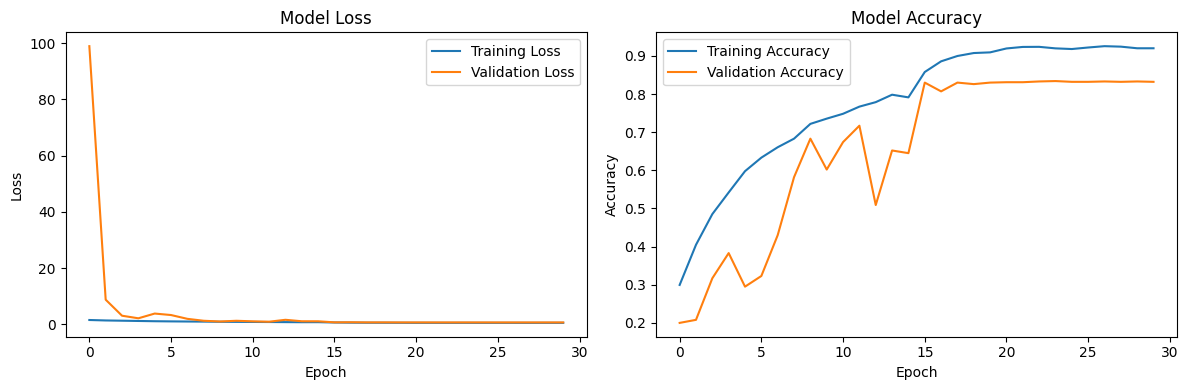

In [16]:
# 훈련 기록 시각화
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 손실 그래프
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 정확도 그래프
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)